# Energy spectrum

I calculate the energy spectrum of bacterial turbulence in this notebook. Energy spectrum quantifies the energy distribution over different length scales, $\lambda=2\pi/k$, where $k$ is the wavenumber. To obtain the energy spectrum, we first calculate the Fourier trransform of the 2D velocity field $v_x(x, y)$ and $v_y(x, y)$ to obtain $u_k(k_x, k_y)$ and $v_k(k_x, k_y)$. The point wise kinetic energy density in the k-space is then computed as $E(k_x, k_y) = \langle u_k(k_x, k_y)u^*_k(k_x, k_y)+v_k(k_x, k_y)v_k^*(k_x, k_y)\rangle/2$, where \* represents the complex conjugate. Finally, the energy spectrum E(k) is obtained by summing up $E(k_x, k_y)$ at a constant $k=(k_x^2+k_y^2)^{1/2}$. 

An alternative way to calculate $E(k)$ is through the Fourier transform of the two-point velocity correlation function $\langle v(r_0)\cdot v(r_0+r)\rangle_{r_0}$, which should yields quantitatively similar results.

## <font color='blue'> Plans

<font color='blue'>
- ...
    
</font>

## Table of contents

1. Construct a 2D fftfreq function
    - Test `numpy.fft.fftfreq()`
    - test inverse FT
    - 2D fftfreq function
2. Fit spectrum curve with formula [Bardfalvy 2019](https://pubs.rsc.org/en/content/articlelanding/2019/sm/c9sm00774a#!divAbstract)
    - Construct the formula and try to plot with relevant parameters
    - Fit the lowest density curve
3. Plot energy spectra
    - Extract data from summary.csv
    - Plot energy spectra using the data generated above
    - Plot low density fitting
4. Compare energy spectra and GNF
    - compare scaling exponents of GNF $\alpha$ and energy spectrum $\beta$
    - steady-state $E$ and GNF $\Delta N/\sqrt N$ at each length scale
    - transient $E$ and GNF $\Delta N/\sqrt N$ at each length scale and each time

## 0 Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from corr_utils import *
import typesetting.main as tm
from corrLib import *
from scipy.integrate import *
from scipy.special import kn
from scipy.optimize import curve_fit
from IPython.display import clear_output
from scipy import signal
from log import experiment_log

<font color='red'>**CHECK AND RUN THE BLOCK BELOW TO INITIATE ESSENTIAL VARIABLES**</font>

In [2]:
color_dict, marker_list = unified_symbols() # keep color and symbol consistent across different plot, for same concentrations
data_master_dir = r'I:\Google Drive' # data folder: Google drive for now, but may change in the future
tm.prl('1-column-2-panel') # control the default plotting configurations, now I realize the parameters should vary from plot to plot
log_df = experiment_log()
n0_to_vf = 0.08 # n0 to volume fraction

-------The log looks OK!--------


S:\Anaconda\3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## 1 Construct a 2D fftfreq function

`numpy` has a built-in function `numpy.fft.fftfreq()` for calculating wavenumber field for 1-D data. We first test this function, and then implement a 2-D version based on it.

### 1.1 Test `numpy.fft.fftfreq()`
Apply this function on a function with known wavenumber peak(s), and calibrate the parameter until the function returns the expected wavenumber. For example, function $f(x)=\cos x$, the wave number corresponding to the peak is $1/2\pi$, around 0.159.

E:\anaconda\miniconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


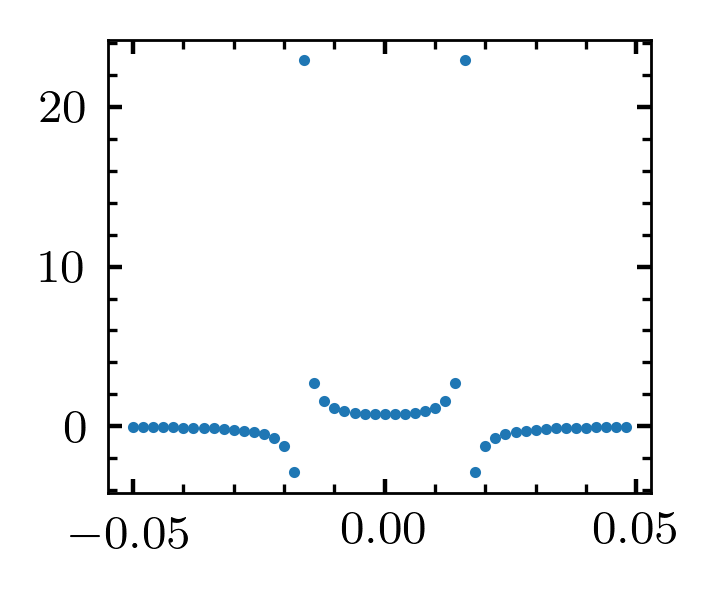

In [143]:
x = np.linspace(0, 50)
y = np.cos(x)
d = 10
fft = np.fft.fft(y)
freq = np.fft.fftfreq(len(x), d=10)
plt.plot(freq, fft, ls='', marker='o', markersize=1)

When the parameter $d$ of function `numpy.fft.fftfreq(len, d)` is set to 1, the distance between adjacent data point in $x$, the peak wavenumber is the same as expected. Thus, if we put the actual distance in certain unit between two adjacent points as $d$, say 8.33 um in this experiment, the resultant $k$ field will have unit um$^{-1}$.

### 1.2 test inverse fft

We testify our Fourier Transform validity by transforming back to the original function. Here the test function is $y = \cos x$ in the range (0, L). 

We start off by writing down the FT in continuous space:
$$
\hat V(k) = \int_0^L V(x) \exp \{-i2\pi kx\} dx
$$

We now discretize the FT on a discretized wavenumber space $k_p$ where $p = 0, 1, ..., n-1$. By default, the `numpy.fft.fft` method uses (0, $1/L$, $2/L$, ..., $-2/L$, $-1/L$) as the wavenumber space $k_p$. This choice overlooks the very high frequency signal, which is typically not important. Suppose the original $V$ field has $n$ discrete value from 0 to $L$, $x$ can now be written as $x = mL/n$, where $m = 0, 1, ..., n-1$ and $dx$ can be written as $dx = L/n$. With these information, we can now write the discretized FT:
$$
\hat V_p = \sum\limits_{m=0}^{n-1} V_m \exp\{ -i2\pi k_p \frac{mL}{n} \} \frac{L}{n}
$$

where $\hat V_p$ is corresponding to the coefficient of the term with wavenumber $k_p$, i.e. $\exp\{ i 2\pi k_p \frac{mL}{n} \}$.

We note here that, $\sum\limits_{m=0}^{n-1} V_m \exp\{ -i 2\pi k_p \frac{mL}{n} \}$ is the standard `numpy.fft.fft` method and $\frac{L}{n}$ is and extra term.

Now, we combine `numpy.fft.fft` and our manual summation to testify our result using $y=\cos x$, as mentioned earlier.

E:\anaconda\miniconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$\\hat V$')

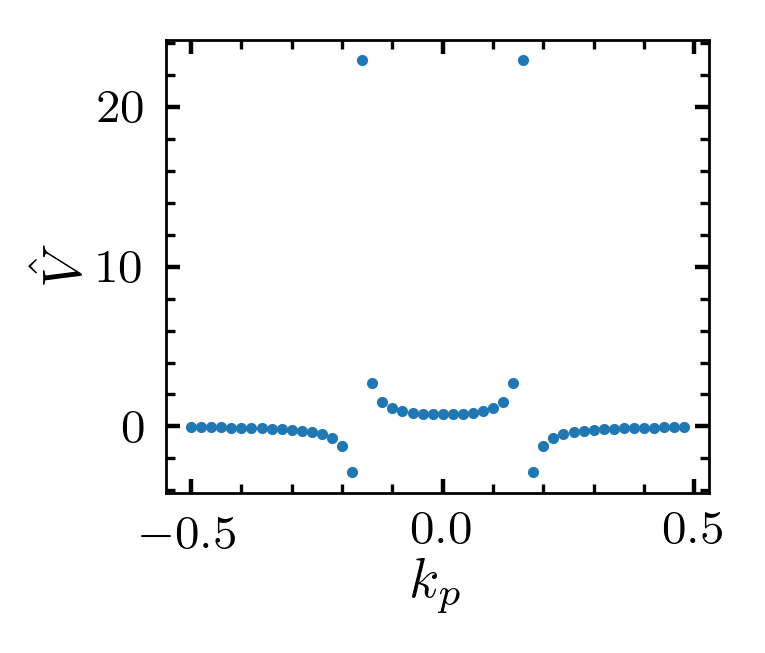

In [292]:
n = 50
L = 50
x = np.linspace(0, L, n)
dx = L / n
y = np.cos(x)
V_hat = np.fft.fft(y) * L / n
k_p = np.fft.fftfreq(n, d=dx)
plt.plot(k_p, V_hat, ls='', marker='o', markersize=1)
plt.xlabel('$k_p$')
plt.ylabel('$\hat V$')

We anticipate that by calculating the inverse FT manually, we can get the $y=\cos x$ function back. The formula we will use is the following:
$$
V_m = \sum\limits_{p=0}^{n-1} \hat V_p \exp\{ i m\frac{L}{n} k_p \} \frac{1}{L}
$$

Note that $mL/n$ is just $x$ and $1/L$ is the distance between adjacent $k_p$.

The following block performs this calculation. $\hat V_p$ is a vector with shape (1, n), i.e. `V_hat.real.reshape((1, n))`. $\exp\{ i 2\pi m\frac{L}{n} k_p \}$ is a (n, n) matrix, since the summation is over $p$, $m$ will be put at the end of the outer product to form a $m$-column vector. 

E:\anaconda\miniconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


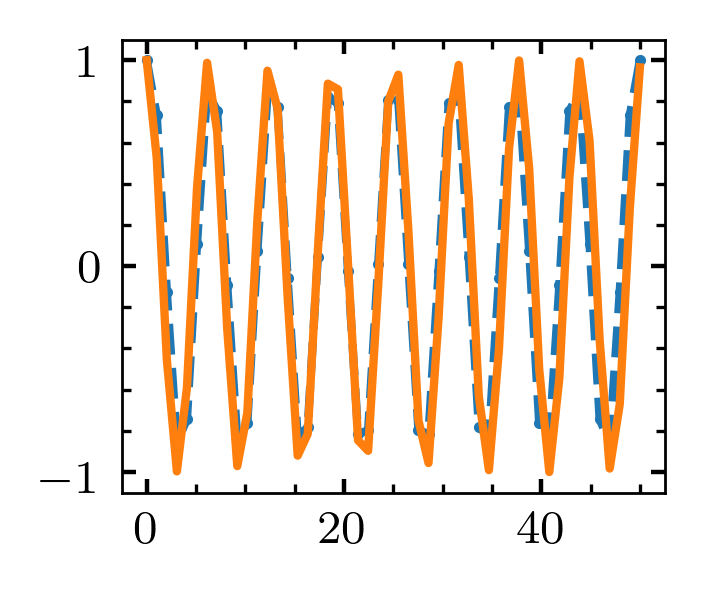

In [299]:
f = np.matmul(V_hat.real.reshape((1, n)), np.exp(1j*np.outer(k_p, x)*2*np.pi)) / L
plt.plot(x, f.flatten(), ls='--', marker='o', markersize=1)
plt.plot(x, y)

The manually inversed function agrees with the original function very well, suggesting that our understanding of `numpy.fft.fft` is correct. When one tries to calculate the exact coefficient of a mode, a length scale $L/n$, where $L$ is the total length and $n$ is the number of points, should be multiplied to the return value of `numpy.fft.fft` function.

### 1.3 2D fftfreq function

In [11]:
help(compute_wavenumber_field)

Help on function compute_wavenumber_field in module corrLib:

compute_wavenumber_field(shape, d)
    Compute the wave number field Kx and Ky, and magnitude field k. 
    Note that this function works for even higher dimensional shape.
    
    Args:
    shape -- shape of the velocity field and velocity fft field, tuple
    d -- sample spacing. This is the distance between adjacent samples, for example, velocities in PIV. 
        The resulting frequency space has the unit which is inverse of the unit of d. The preferred unit of d is um.
    
    Returns:
    k -- wavenumber magnitude field
    K -- wavenumber fields in given dimensions
    
    Test:
    shape = (5, 5)
    k, K = compute_wavenumber_field(shape, 0.2)



## 2 Fit spectrum curve with formula
$$
E_k = 4\pi n \kappa^2 \left[ \frac{1}{3} + \frac{\cos(kl)}{(kl)^2} - \frac{\sin(kl)}{(kl)^3} \right] \frac{\epsilon^4k^2}{l^2} K_2^2(k\epsilon)
$$
- $\kappa$ is dipole strength, and can be calculated as $\kappa = Fl/\eta$, where $F$ is the dipolar force, $l \approx 1.9$ um is the dipole length and $\eta$ the viscosity of fluid, typically $\kappa=590$ $\mu$m$^3\cdot$s
- $\epsilon$ is a factor describing the distance over which the regularisation acts, typically $\epsilon = 1$
- and $K_2$ is the modified Bessel function of the second kind, and can be computed using `scipy.special.kn`, use `K2 = kn(2, x)`, [reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kn.html#scipy.special.kn)
- Estimate the length scale in the simulation:
    - $\phi = (4\pi/3)a^3n$, $a = 0.3$
    - typical _E. coli_ is $1\times1\times1$ um$^3$, so 1 um corresponds to 0.3 in the simulation unit
    - the wavenumber unit is thus 1/(3.33um) = 0.3 um$^{-1}$

### 2.1 Construct the formula and try to plot with relevant parameters

In [9]:
def E_k(k, n, ep = 1):
    """
    Energy spectrum in active turbulence | Boltzmann Lattice simulation | reference Bardfalvy 2019
    https://pubs.rsc.org/en/content/articlelanding/2019/sm/c9sm00774a#!divAbstract
    
    k -- wavenumber (um^-1)
    ep -- a factor describing the distance over which the regularisation acts
    
    Additional info:
    kappa = Fl / mu
    """
    # kappa based on flow measurement (Bardfalvy 2019 and Drescher 2011)
#     l = 1.9 # um
#     F = 0.32e-12 # N
#     mu = 0.001e-12 # N / um^2 * s
#     kappa = F * l / mu # um^3 * s
    # below is the new calculation of kappa based on body geometry (Magariyama 2002)
    wb = 0.65 # um
    lb = 3 # um
    v0 = 15 # um/s
    l = 1.9 # um
    kappa = 3 * np.pi * wb * (1-(1-lb/wb)/5) * v0 * l
    kappa # um^3/s
    
    K_2 = kn(2, k*ep)   
    
    Ek = 4 * np.pi * n * kappa**2 * (1/3 + np.cos(k*l)/(k*l)**2 - np.sin(k*l)/(k*l)**3) * ep**4 * k**2 / l**2 * K_2 ** 2
    
    return Ek

([<matplotlib.axis.XTick at 0x20937e8f988>,
 <a list of 3 Text major ticklabel objects>)

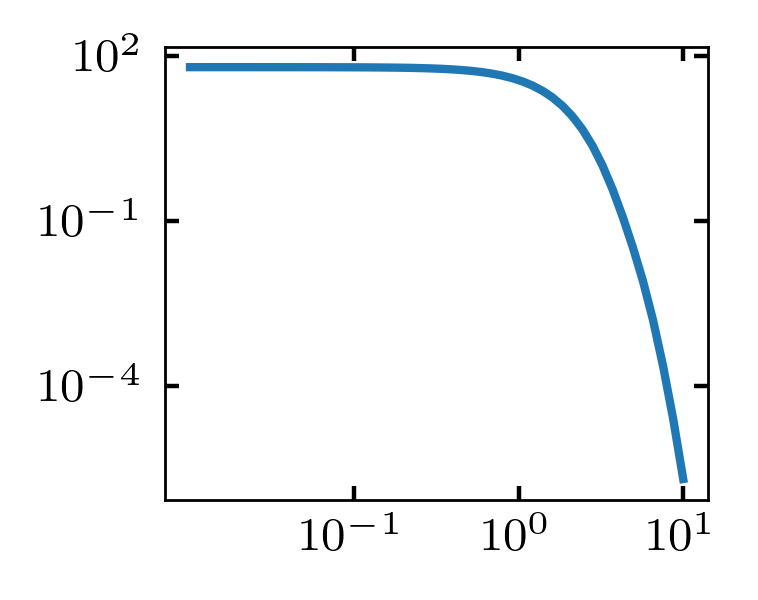

In [29]:
k = np.logspace(-2, 1)
n = 0.0001
Ek = E_k(k, n)
plt.plot(k, Ek)
plt.loglog()
plt.xticks([0.1, 1, 10])

### 2.2 Fit the lowest density curve

E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


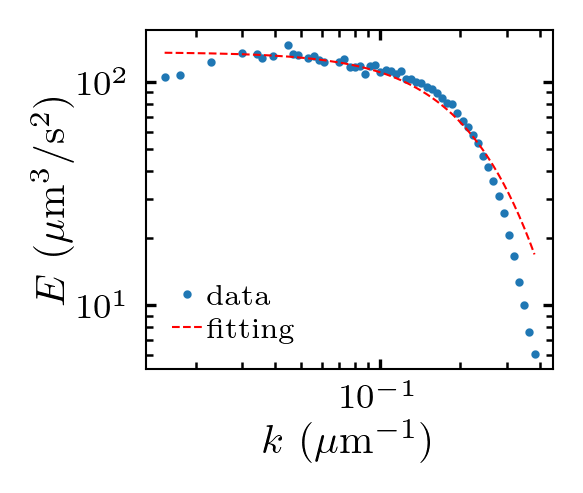

In [181]:
summary = pd.read_csv(os.path.join(r'E:\moreData\08042020\energy_spectrum_10\summary.csv')).set_index('k')
s = range(9, 12)
for count, num in enumerate(s):
    temp_data = summary.loc[summary['sample'].astype('int')==num]
    if count == 0:
        data = temp_data
    else:
        data += temp_data
data /= count + 1
x, y = xy_bin(data.index, data.E)
y *= 2*np.pi*x 

xx = x[(np.isnan(y)==False)&(x!=0)]
yy = y[(np.isnan(y)==False)&(x!=0)]
xfit = xx[xx<4e-1]
yfit = yy[xx<4e-1]
popt, pcov = curve_fit(E_k, xfit, yfit)
plt.figure(dpi=300)
plt.plot(xfit, yfit, ls='', marker='o', markersize=1, label='data')
plt.plot(xfit, E_k(xfit, *popt), ls='--', color='red', lw=0.5, label='fitting')

plt.loglog()
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.legend(loc='lower left', fontsize=7)

## 3 Plot energy spectra with fitting

### 3.1 Extract data from summary.csv

Here, we use the data in data_master_dir, i.e. Google Drive data. Make sure all summary.csv files are synced before running the block below.

In [36]:
log_140 = log_df.loc[log_df['thickness']==140].sort_values(by='conc')
master_es = pd.DataFrame()
for c in log_140['conc'].drop_duplicates():
    log_conc = log_140.loc[log_140['conc']==c]
    for num, i in log_conc.iterrows():
#         summary = pd.read_csv(os.path.join(data_master_dir, 
#                                            r'Research projects\DF\data\level-2-data\{}\energy_spectrum_10\summary.csv') \
#                               .format(i['date'])).set_index('k')
        for count, n in enumerate(log_conc['run_number']):
#             temp_data = summary.loc[summary['sample'].astype('int')==n]
            temp_data = pd.read_csv(os.path.join(data_master_dir,
                                                r'Research projects\DF\data\level-2-data\08032020\energy_spectrum_10\summary'))
            if count == 0:
                data = temp_data
            else:
                data += temp_data                
        data /= count + 1
        x, y = xy_bin(data.index, data.E) # bin the data to reduce and evenly distribute the data points
        y *= 2 * np.pi * x # convert 2D data to 1D data
        temp_es = pd.DataFrame({'k': x, str(int(c)):y}).set_index('k')
    master_es = pd.concat([master_es, temp_es], axis=1)
master_es = master_es.dropna(how='all', axis=0)
# master_es.to_csv(save_file) # save data in .csv file

I:\Github\Python\Correlation\src\corr_utils.py:1263: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


In [37]:
master_es

,0.0,0.0,0.0
k,,,
0.008000,NaN,NaN,NaN
0.008434,NaN,NaN,NaN
0.008892,NaN,NaN,NaN
0.009375,NaN,NaN,NaN
0.009884,NaN,NaN,NaN
0.010420,NaN,NaN,NaN
0.010986,NaN,NaN,NaN
0.011583,NaN,NaN,NaN
0.012211,NaN,NaN,NaN


In [24]:
summary.head()

,E,sample
k,,
0.000000,248006.81321,0
0.015312,336563.30154,0
0.015312,336563.30154,0
0.018257,293430.34103,0
0.018257,293430.34103,0


In [23]:
log_conc

,run_number,conc,FPS,MPP,length,exposure_time,thickness,date
3,3,120.0,30,0.33,3600,3,140.0,08062020
4,4,120.0,30,0.33,3600,3,140.0,08062020
5,5,120.0,30,0.33,3600,3,140.0,08062020


In [6]:
save_file = os.path.join(data_master_dir, r'Research projects\DF\data', 'energy-spectra.csv')
conc, folders, sample_num = tentative_log()
master_es = pd.DataFrame() # Initiate an empty DF to save energy spectrum data
for c, f, s in zip(conc, folders, sample_num):
    summary = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\level-2-data', f, r'energy_spectrum_10\summary.csv')).set_index('k')
    for count, num in enumerate(s):
        temp_data = summary.loc[summary['sample'].astype('int')==num]
        if count == 0:
            data = temp_data
        else:
            data += temp_data
    data /= len(s)
    x, y = xy_bin(data.index, data.E) # bin the data to reduce and evenly distribute the data points
    y *= 2 * np.pi * x # convert 2D data to 1D data
    temp_es = pd.DataFrame({'k': x, str(c):y}).set_index('k')
    master_es = pd.concat([master_es, temp_es], axis=1)
master_es = master_es.dropna(how='all', axis=0)
master_es.to_csv(save_file) # save data in .csv file

I:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
I:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
I:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
I:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
I:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
I:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
I:\Github\Python\Correlation\src\corr_utils.py:1301: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
I:\Github\Python\Correlation\src\corr_utils.py:1

### 3.2 Plot energy spectra using the data generated above

The "energy-spectra.csv" data saved in DF/data folder will be used as the main data for energy spectra plots. 

Text(0, 0.5, '$E$ ($\\mu$m$^3$/s$^2$)')

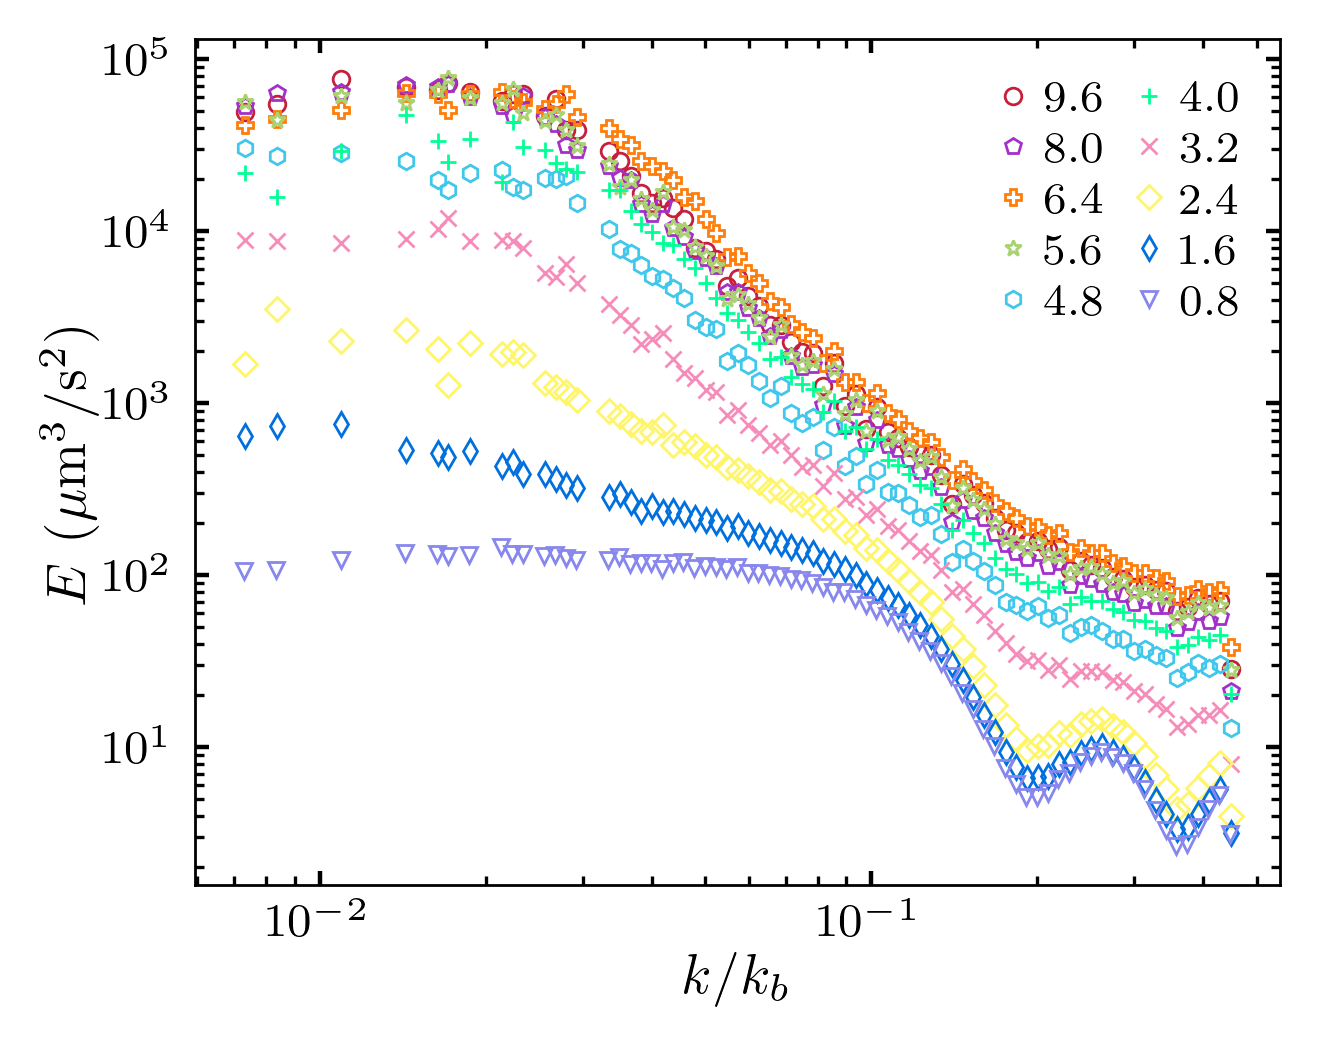

In [45]:
data_es = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data', 'energy-spectra.csv')).set_index('k').sort_index()
k_max = 0.15 * 2 * np.pi# set the maximal k up to which we plot the data (um^-1)
data_es_trim = data_es[:k_max]
kb = 2 * np.pi / 3
fig, ax = plt.subplots(figsize=(3.5, 2.8))
for str_c in data_es_trim:
    if str_c != '85':
        ax.plot(data_es_trim.index/kb, data_es_trim[str_c], label='{:.1f}'.format(int(str_c)*0.08), ls='', 
                marker=marker_list[color_dict[str_c]], markersize=3, mew=0.5,
                mec=wowcolor(color_dict[str_c]), mfc=(0,0,0,0))
ax.legend(loc='upper right', ncol=2, fontsize=8)
ax.loglog()
ax.set_xlabel('$k/k_b$')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')

### 3.3 Plot low density fitting

array([8.97557287e-04, 1.43098762e+01])

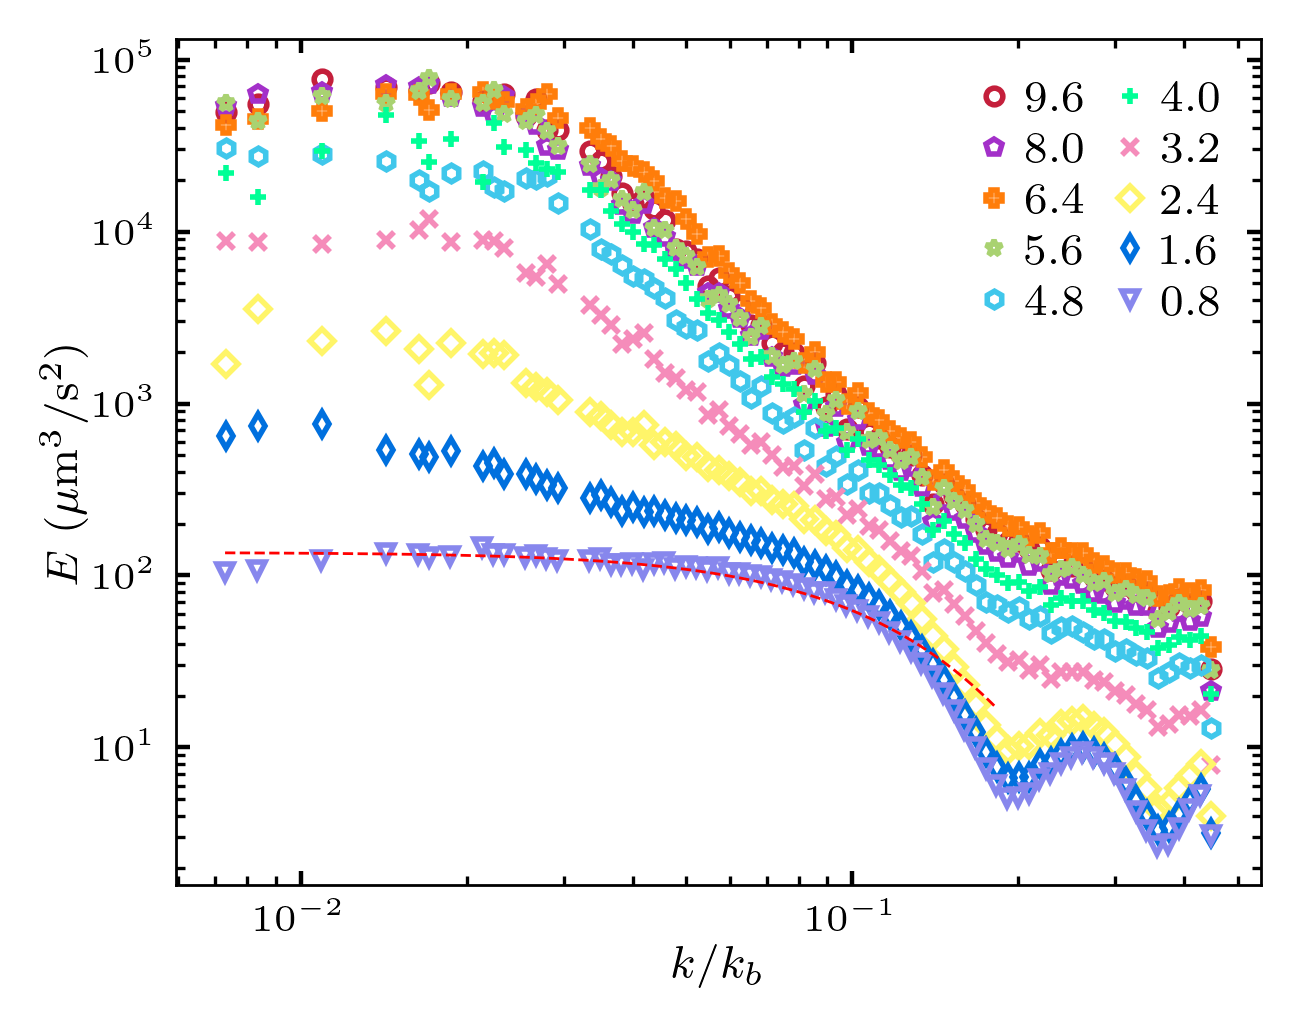

In [11]:
data_es = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\energy-spectra', 'energy-spectra.csv')).set_index('k').sort_index()
k_max = 0.15 * 2 * np.pi# set the maximal k up to which we plot the data (um^-1)
data_es_trim = data_es[:k_max]
kb = 2 * np.pi / 3
fig, ax = plt.subplots(figsize=(3.5, 2.8))
for str_c in data_es_trim:
    if str_c != '85':
        ax.plot(data_es_trim.index/kb, data_es_trim[str_c], label='{:.1f}'.format(int(str_c)*0.08), ls='', 
                marker=marker_list[color_dict[str_c]], markersize=3, mew=1,
                mec=wowcolor(color_dict[str_c]), mfc=(0,0,0,0))
        
ax.legend(loc='upper right', ncol=2, fontsize=8)
ax.loglog()
ax.set_xlabel('$k/k_b$')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')

fitting_max = 0.4 # set the range for fitting
data_fit = data_es[:fitting_max]['10'].dropna()
popt, pcov = curve_fit(E_k, data_fit.index/kb, data_fit)
ax.plot(data_fit.index/kb, E_k(data_fit.index/kb, *popt), ls='--', color='red', lw=0.5, label='fitting')
popt

$$
\xi = 3\pi\eta w_b[1-(1-l_b/w_b)/5]
$$
$$
\kappa = 3\pi w_b [1-(1-\frac{l_b}{w_b})/5] v_0 l_d
$$

In [8]:
wb = 0.65 # um
lb = 3 # um
v0 = 15 # um/s
ld = 1.9 # um
kappa = 3 * np.pi * wb * (1-(1-lb/wb)/5) * v0 * ld
kappa # um^3/s

300.83891250775855

## 4 Compare energy spectra and GNF

### 4.1 Compare scaling exponents of GNF $\alpha$ and enrgy spectrum $\beta$
The $alpha$ fitting has been taken care of in the GNF notebook. Here, we only fit the energy spectra data for $\beta$.
#### 4.1.1 Fit for beta

$\beta$ is fitted in the range **(0.03, 0.08)** (kb). If changes are made to this range, also change this description.

In [60]:
data_es = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\energy-spectra', 'energy-spectra.csv')).set_index('k').sort_index()
kb = 2 * np.pi / 3
data_trim = data_es[0.03*kb: 0.08*kb]
beta_list = []
for str_c in data_trim:
    data_fit = data_trim[str_c].dropna()
    p = np.polyfit(np.log(data_fit.index), np.log(data_fit), deg=1)
    beta_list.append(-p[0])

In [62]:
# Save data in data/beta.csv
beta = pd.DataFrame({"conc": data_es.keys().astype('int'), "beta": beta_list}).set_index('conc').sort_index()
beta.to_csv(os.path.join(data_master_dir, r'Research projects\DF\data\energy-spectra\beta.csv'))

#### 4.1.2 Plot $\beta$ vs. $\phi$

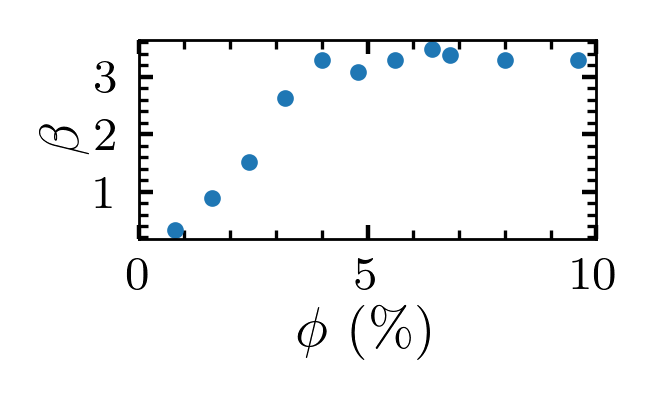

In [50]:
beta = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\energy-spectra\beta.csv'))
fig, ax = plt.subplots(figsize=(1.8, 1.1))
ax.plot(beta.conc*0.08, beta.beta,
        ls='', marker='o', markersize=2)
ax.set_xlabel('$\phi$ (\%)')
ax.set_ylabel('$\\beta$')
ax.set_xlim([0, 10])
plt.tight_layout()

#### 4.1.3 Plot $\alpha$ and $\beta$ together

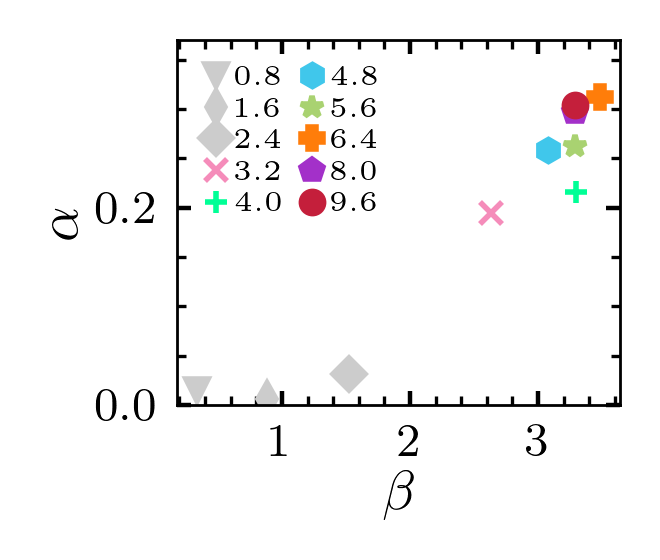

In [65]:
alpha_data = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\GNF\alpha.csv')).set_index('conc').drop(index=85)
beta_data = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\energy-spectra\beta.csv')).set_index('conc').drop(index=85)
fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(3.5, 1.6))
for c in alpha_data.index:
    if c < 40:
        ax.plot(beta_data['beta'][c], alpha_data['mean'][c], ls='', marker=marker_list[color_dict[str(c)]], 
                markersize=4, color=(0.8, 0.8, 0.8), label='{:.1f}'.format(c*0.08))
    else:
        ax.plot(beta_data['beta'][c], alpha_data['mean'][c], ls='', marker=marker_list[color_dict[str(c)]], 
                markersize=4, color=wowcolor(color_dict[str(c)]), label='{:.1f}'.format(c*0.08))
ax.set_ylim([0, 0.37])
ax.legend(loc='upper left', ncol=2, fontsize=5)
ax.set_xlabel('$\\beta$')
ax.set_ylabel('$\\alpha$')
plt.tight_layout()

#### 4.1.3 Ratio between $\alpha$ and $\beta$

In [80]:
alpha_data = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\GNF\alpha.csv')).set_index('conc').drop(index=85)
beta_data = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\energy-spectra\beta.csv')).set_index('conc').drop(index=85)
r = alpha_data['mean'] / beta_data['beta']
r = r.loc[r.index>=40]
print("mean: {0:.3f}, std: {1:.3f}".format(r.mean(), r.std()))

mean: 0.082, std: 0.010


### 4.2 Steady-state $E$ and GNF $\Delta N/\sqrt N$ at each length scale

#### 4.2.1 Generate energy spectrum data

The steady state plot can be done by extracting the last columns of transient data. So we only generate transient energy spectrum data here, which will be saved in folder data\transient-nGNF-energy.

In [5]:
conc, folders, sample_num = tentative_log()
lb = 3 # um
d = 10 * 0.33 # um, PIV step size
for c, f, sn in zip(conc, folders, sample_num):    
    for n in sn:
        # determine paramters of function construct_spectra_series
        data_gnf_sample = pd.read_csv(os.path.join(data_master_dir, r'Research projects\DF\data\transient-GNF-energy-dN', 
                                                   r'{0}\df2_kinetics\{1:02d}\nGNF_data.csv'.format(f, n))).set_index('l_r')
        bins = 2 * np.pi / (np.concatenate(([0.1], (np.array(data_gnf_sample.index)))) ** 0.5 * lb) 
        t_list = data_gnf_sample.keys().astype('int')
        piv_folder = r'I:\moreData\{0}\piv_step_10\{1:02d}'.format(f, n)
        # call function construct_spectra_series()
        es_series = construct_spectra_series(piv_folder, t_list, bins, d=d)
        dest_folder = os.path.join(data_master_dir, r'Research projects\DF\data\transient-GNF-energy-dN', 
                                                   r'{0}\energy_spectra\{1:02d}'.format(f, n))
        if os.path.exists(dest_folder) == False:
            os.makedirs(dest_folder)
        es_series.to_csv(os.path.join(dest_folder, 'energy_spectra.csv'))
        print(dest_folder.replace(os.path.join(data_master_dir, r'Research projects\DF\data\transient-GNF-energy-dN'), ''))
        clear_output(wait=True)

I:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  x = np.linspace(xo.min(), xo.max(), n+1)
I:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  x = np.linspace(xo.min(), xo.max(), n+1)
I:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  x = np.linspace(xo.min(), xo.max(), n+1)
I:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  x = np.linspace(xo.min(), xo.max(), n+1)
I:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  x = np.linspace(xo.min(), xo.max(), n+1)
I:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  x = np.linspace(xo.min(), xo.max(), n+1)
I:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value

\08042020\energy_spectra\11


I:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  x = np.linspace(xo.min(), xo.max(), n+1)


#### 4.2.2 Plot steady-state $E$ and $\Delta N / \sqrt N$

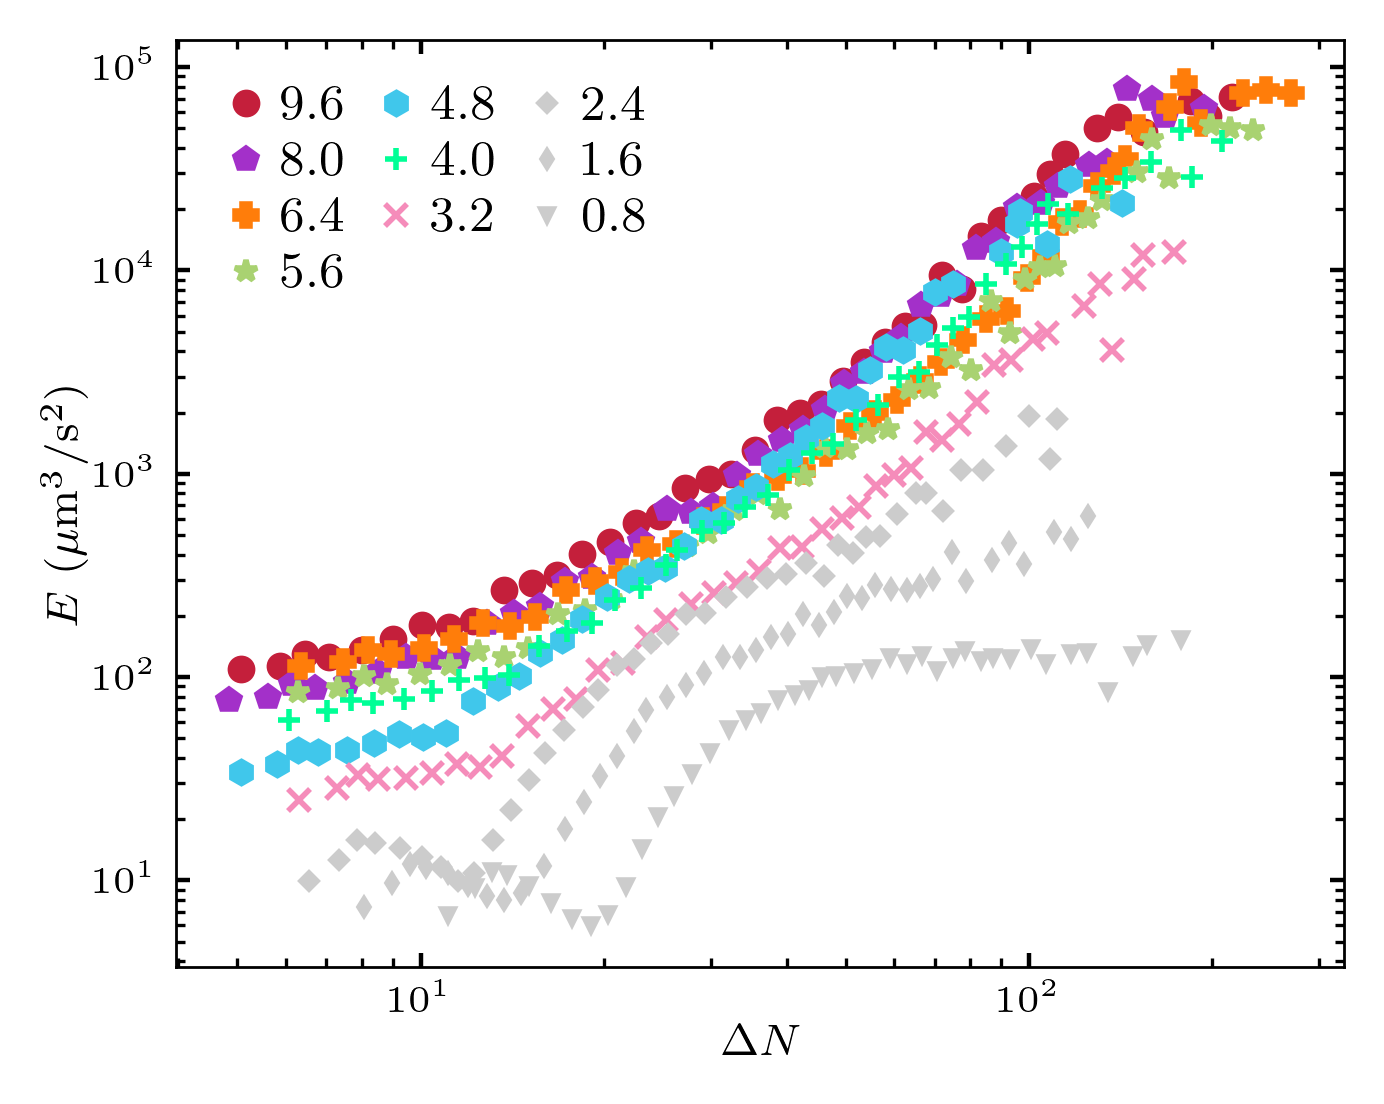

In [17]:
conc, folders, sample_num = tentative_log()
gnf_master_file = os.path.join(data_master_dir, 
                               r'Research projects\DF\data\transient-GNF-energy-dN\{0}\df2_kinetics\{1:02d}\nGNF_data.csv')
es_master_file = os.path.join(data_master_dir, 
                               r'Research projects\DF\data\transient-GNF-energy-dN\{0}\energy_spectra\{1:02d}\energy_spectra.csv')
bounds = [10, 3000]

fig, ax = plt.subplots(figsize=(3.5, 2.8))
for c, f, sn in zip(conc, folders, sample_num):
    n = sn[1]
    gnf_data = pd.read_csv(gnf_master_file.format(f, n)).set_index('l_r')[bounds[0]: bounds[1]]
    es_data = pd.read_csv(es_master_file.format(f, n)).set_index('l_r')[bounds[0]: bounds[1]]
    gnf_plot = gnf_data.drop(labels=gnf_data.keys()[:-15], axis=1).mean(axis=1)
    es_plot = es_data.drop(labels=es_data.keys()[:-15], axis=1).mean(axis=1)
    if c > 30 and c != 85: # and c != 60:
        ax.plot(gnf_plot/c**0.5, es_plot, 
                ls='', marker=marker_list[color_dict[str(c)]], markersize=4, 
                color=wowcolor(color_dict[str(c)]), label='{:.1f}'.format(c*n0_to_vf))
    elif c <= 30:
        ax.plot(gnf_plot/c**0.5, es_plot, 
                ls='', marker=marker_list[color_dict[str(c)]], markersize=2, 
                color=(0.8, 0.8, 0.8), label='{:.1f}'.format(c*n0_to_vf))
ax.loglog()
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.set_xlabel('$\Delta N$')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.tight_layout()

# fitting curve
# p = np.array([ 0.30918824, -1.45846505,  4.89021747])
# x = np.logspace(1.8, 3.2)
# logx = np.log(x)
# y = np.exp(p[0]*logx**2 + p[1]*logx + p[2])
# ax.plot(x, y, ls='--', lw=1.5, color='black')

#### 4.2.3 Fit the master curve with a polynomial

In [18]:
conc, folders, sample_num = tentative_log()
gnf_master_file = os.path.join(data_master_dir, 
                               r'Research projects\DF\data\transient-GNF-energy-dN\{0}\df2_kinetics\{1:02d}\nGNF_data.csv')
es_master_file = os.path.join(data_master_dir, 
                               r'Research projects\DF\data\transient-GNF-energy-dN\{0}\energy_spectra\{1:02d}\energy_spectra.csv')
bounds = [10, 3000]

# fig, ax = plt.subplots(figsize=(3.5, 2.8))
x = pd.DataFrame()
y = pd.DataFrame()
for c, f, sn in zip(conc, folders, sample_num):
    if c > 50:
        n = sn[2]
        gnf_data = pd.read_csv(gnf_master_file.format(f, n)).set_index('l_r')[bounds[0]: bounds[1]]
        es_data = pd.read_csv(es_master_file.format(f, n)).set_index('l_r')[bounds[0]: bounds[1]]
        gnf_plot = gnf_data.drop(labels=gnf_data.keys()[:-15], axis=1).mean(axis=1)
        es_plot = es_data.drop(labels=es_data.keys()[:-15], axis=1).mean(axis=1)
        x = x.append(gnf_plot.to_frame('gnf'))
        y = y.append(es_plot.to_frame('E'))

In [19]:
x = np.array(np.log(x)).flatten()
y = np.array(np.log(y)).flatten()
data = pd.DataFrame({'x': x, 'y': y})

In [20]:
data = data.dropna()

In [57]:
data = data.loc[data.x>1.4]

In [21]:
p = np.polyfit(data.x, data.y, deg=2)

In [22]:
p

array([ 0.30918824, -1.45846505,  4.89021747])

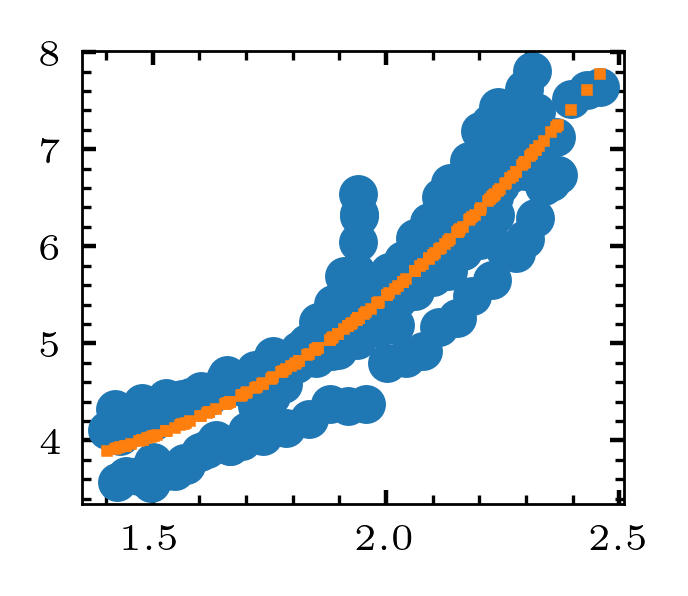

In [62]:
plt.plot(data.x, data.y, ls='', marker='o')
plt.plot(data.x, p[0]*data.x**2+p[1]*data.x+p[2], ls='', marker='s', markersize=1)

### 4.3 Transient $E$ and GNF $\Delta N/\sqrt N$ at each length scale and each time scale

In [26]:
data_master = os.path.join(data_master_dir, r'Research projects\DF\data\transient-GNF-energy-small\{1}\{0}\{2:02d}\{3}')
df_flag = 'df2_kinetics'
es_flag = 'energy_spectra'
df_file = 'nGNF_data.csv'
es_file = 'energy_spectra.csv'

df = {}
es = {}
conc, folders, sample_num = tentative_log()
for date, r, c in zip(folders, sample_num, conc):
    n = r[2]
    df[str(c)] = pd.read_csv(data_master.format(df_flag, date, n, df_file)).set_index('l_r')
    es[str(c)] = pd.read_csv(data_master.format(es_flag, date, n, es_file)).set_index('l_r').sort_index()

Text(59.37854370438113, 0.5, '$E$ ($\\mu$m$^3$/s$^2$)')

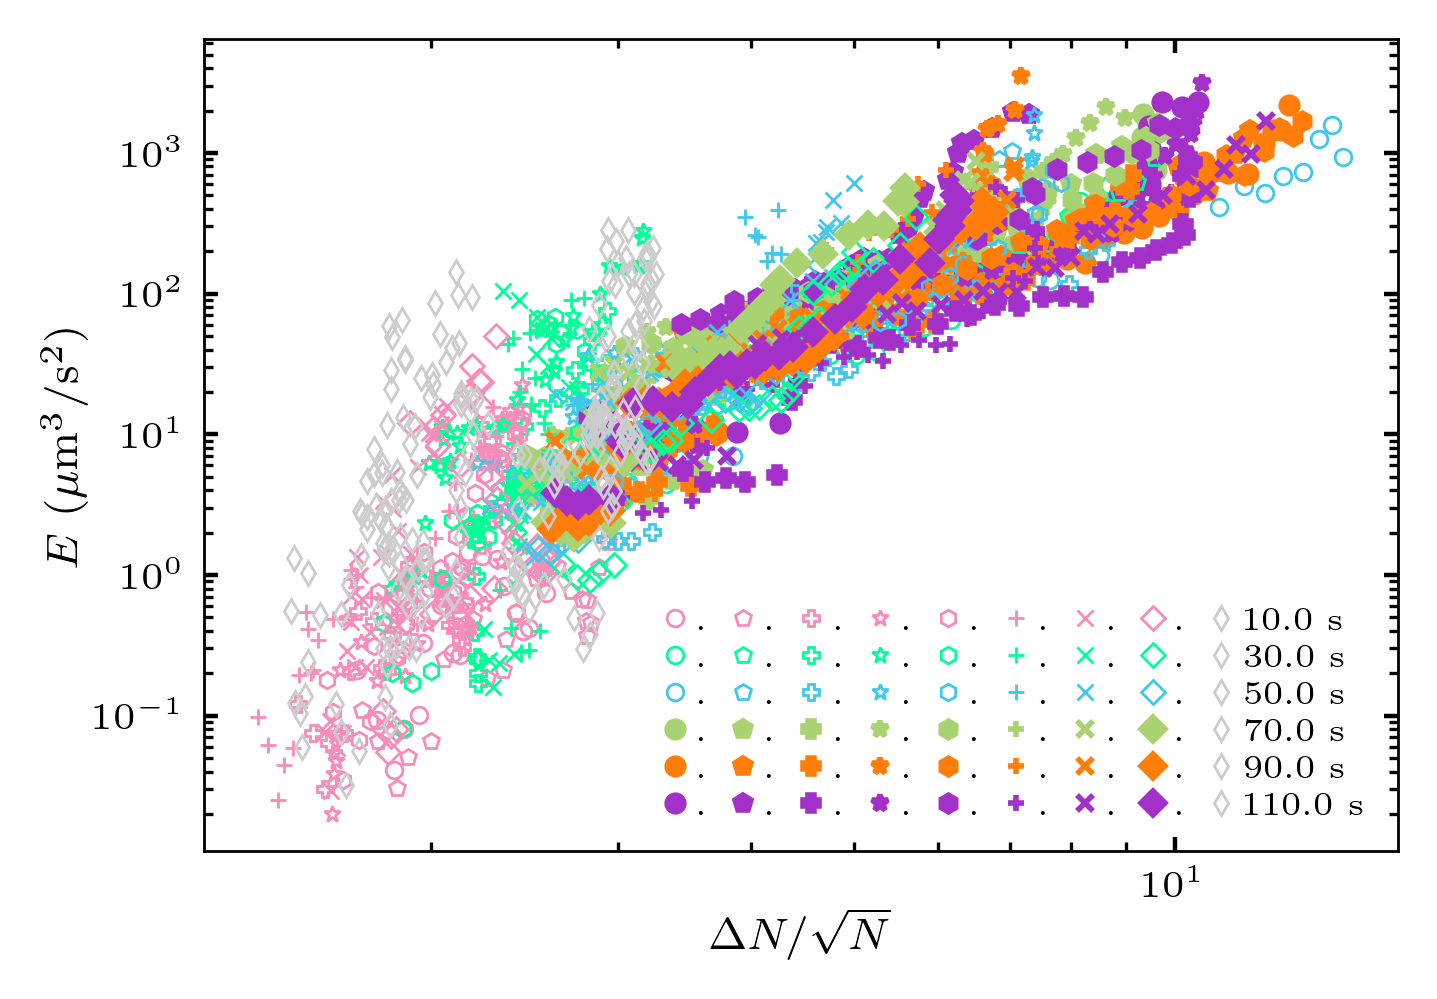

In [28]:
bounds = [0, 200]
fig, ax = plt.subplots(figsize=(3.5, 2.4))
for sample_n, kw in enumerate(df):
    if int(kw) > 30:
        for num, t in enumerate(range(300, 3500, 600)):
            if t < 2000:
                ax.plot(df[kw][str(t)][bounds[0]: bounds[1]], es[kw][str(t)][bounds[0]: bounds[1]], marker=marker_list[sample_n], markersize=3, mfc=(0,0,0,0),
                        mew=0.5, mec=wowcolor(6-num), ls='', label='{}'.format('.'))
            else:
                ax.plot(df[kw][str(t)][bounds[0]: bounds[1]], es[kw][str(t)][bounds[0]: bounds[1]], marker=marker_list[sample_n], markersize=3, ls='', 
                        label='{}'.format('.'), color=wowcolor(6-num))
    elif int(kw) == 30:
        for num, t in enumerate(range(300, 3500, 600)):
            ax.plot(df[kw][str(t)][bounds[0]: bounds[1]], es[kw][str(t)][bounds[0]: bounds[1]], marker=marker_list[sample_n], markersize=3, mfc=(0,0,0,0),
                    mew=0.5, mec=(0.8, 0.8, 0.8), ls='', label='{:.1f} s'.format(t/30))
ax.legend(loc='lower right', fontsize=6, ncol=9)
# ax.legend()
ax.loglog()
plt.tight_layout()
ax.set_xlabel('$\Delta N / \sqrt N$')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')

# fitting curve
# p = np.array([ 0.30918824, -1.45846505,  4.89021747])
# x = np.logspace(1.5, 3.2)
# logx = np.log(x)
# y = np.exp(p[0]*logx**2 + p[1]*logx + p[2])
# ax.plot(x, y, ls='--', lw=1.5, color='black')

Text(87.34906319185, 0.5, '$E(k)$  ($\\mu$m$^3$/s$^2$)')

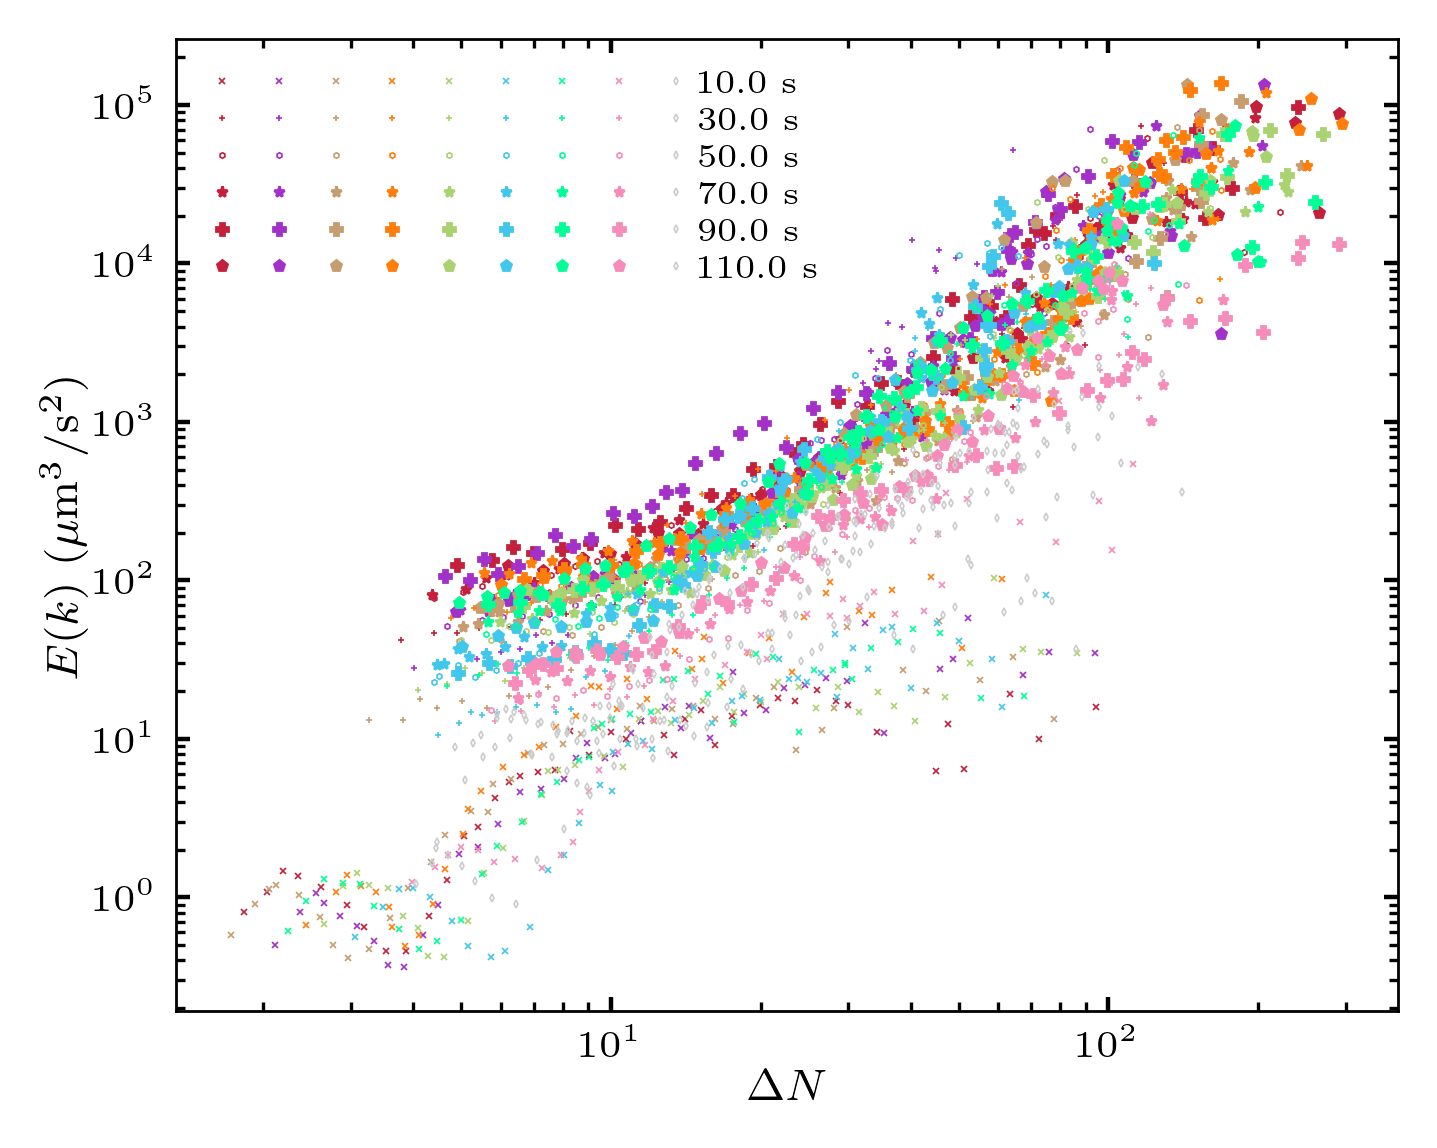

In [16]:
data_master = os.path.join(data_master_dir, r'Research projects\DF\data\transient-GNF-energy-dN\{1}\{0}\{2:02d}\{3}')
df_flag = 'df2_kinetics'
es_flag = 'energy_spectra'
df_file = 'nGNF_data.csv'
es_file = 'energy_spectra.csv'

df = {}
es = {}
conc, folders, sample_num = tentative_log()
for date, r, c in zip(folders, sample_num, conc):
    n = r[1]
    df[str(c)] = pd.read_csv(data_master.format(df_flag, date, n, df_file)).set_index('l_r')
    es[str(c)] = pd.read_csv(data_master.format(es_flag, date, n, es_file)).set_index('l_r').sort_index()
    
bounds = [10, 3000]
fig, ax = plt.subplots(figsize=(3.5, 2.8))
for sample_n, kw in enumerate(df):
    if int(kw) > 30:
        for num, t in enumerate(range(300, 3500, 600)):
            if t < 2000:
                ax.plot(df[kw][str(t)][bounds[0]: bounds[1]]/int(kw)**0.5, es[kw][str(t)][bounds[0]: bounds[1]], 
                        marker=marker_list[6-num], markersize=1, mfc=(0,0,0,0),
                        mew=0.3, mec=wowcolor(color_dict[kw]), ls='', label=' ')
            else:
                ax.plot(df[kw][str(t)][bounds[0]: bounds[1]]/int(kw)**0.5, es[kw][str(t)][bounds[0]: bounds[1]], 
                        marker=marker_list[6-num], markersize=2, ls='', 
                        mew=0.5, label=' ', color=wowcolor(color_dict[kw]))
    elif int(kw) == 30:
        for num, t in enumerate(range(300, 3500, 600)):
            ax.plot(df[kw][str(t)][bounds[0]: bounds[1]]/int(kw)**0.5, es[kw][str(t)][bounds[0]: bounds[1]], 
                    marker=marker_list[sample_n], markersize=1, mfc=(0,0,0,0),
                    mew=0.3, mec=(0.8, 0.8, 0.8), ls='', label='{:.1f} s'.format(t/30))
ax.legend(loc='upper left', fontsize=6, ncol=9)
ax.loglog()
plt.tight_layout()
ax.set_xlabel('$\Delta N$')
ax.set_ylabel('$E(k)$  ($\mu$m$^3$/s$^2$)')

# ax.set_xlim([1, 16])
# ax.set_ylim([1e-5, 5e0])

# fitting curve
# p = np.array([ 0.30918824, -1.45846505,  4.89021747])
# x = np.logspace(1.5, 3.2)
# logx = np.log(x)
# y = np.exp(p[0]*logx**2 + p[1]*logx + p[2])
# ax.plot(x, y, ls='--', lw=1.5, color='black')

#### Plot E and GNF together

In [59]:
# df_table and E_table are ready, save them in the data excel sheet first!
df_table.to_csv(r'C:\Users\liux3141\Google Drive\Research projects\DF\data\df_table.csv')
E_table.to_csv(r'C:\Users\liux3141\Google Drive\Research projects\DF\data\E_table.csv')

In [6]:
# load data
E = pd.read_excel(io=r'E:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='ES_E_table',
                 index_col=0)
df = pd.read_excel(io=r'E:\Google Drive\Research projects\DF\data\new_data_summary.xlsx', sheet_name='ES_df_table',
                 index_col=0)
E = E.loc[E.index < 100]
df = df.loc[df.index < 100]

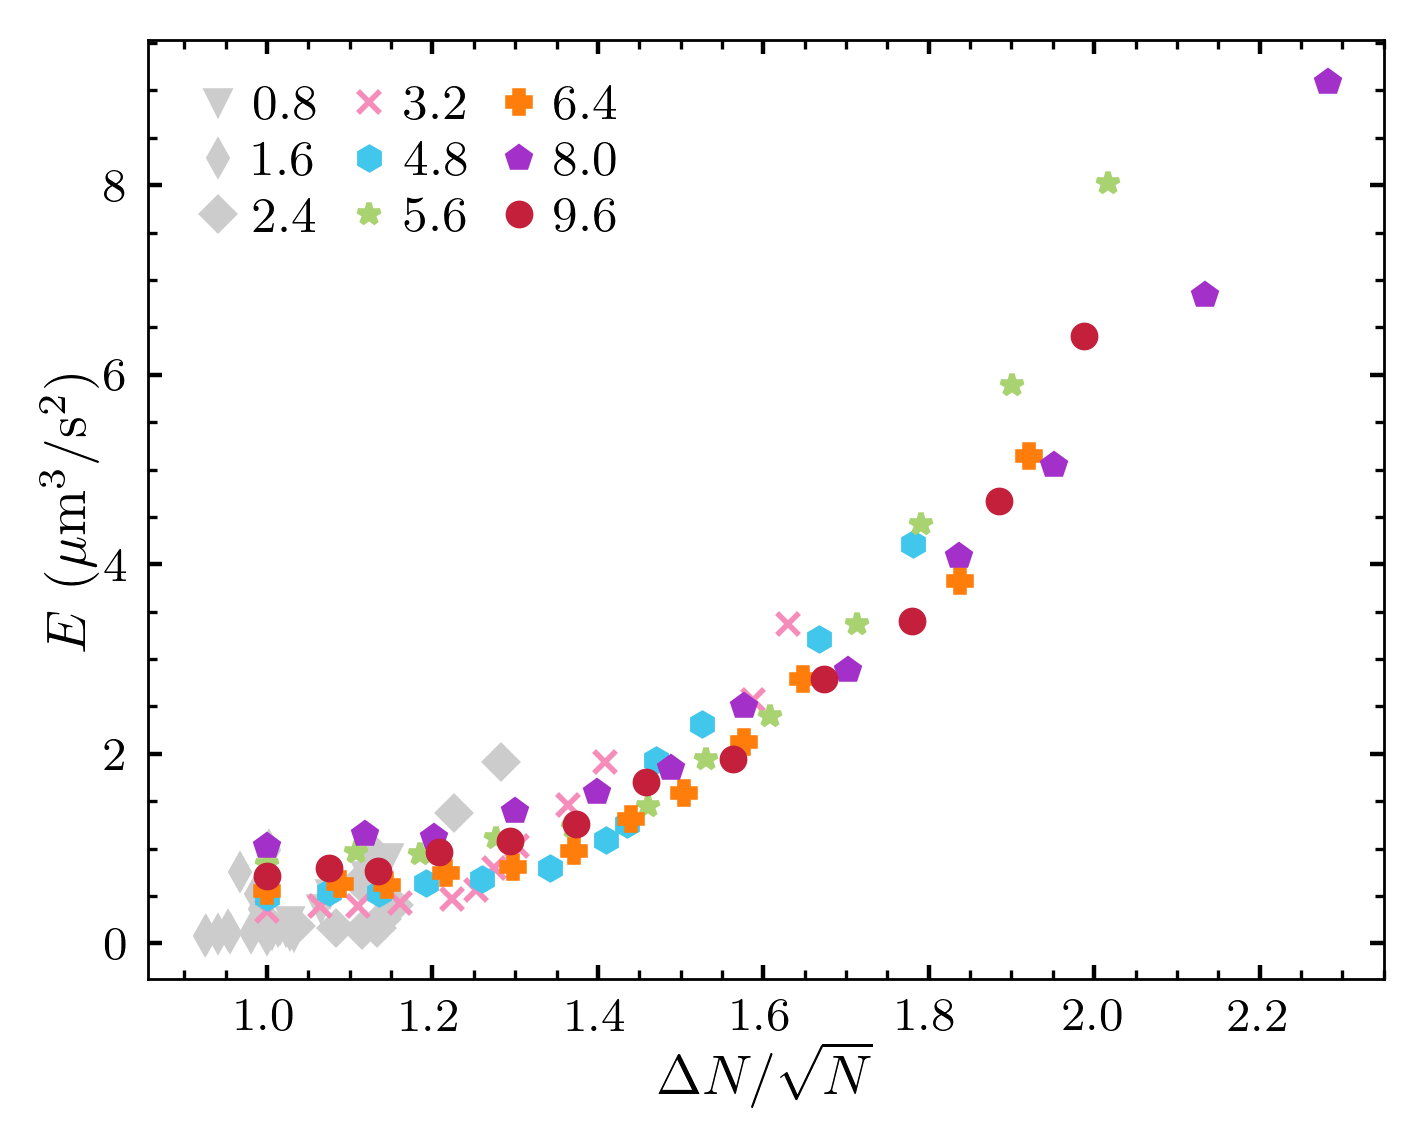

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.8))
count = 0
for kw in E:
    if kw >= 40 and kw != 50:
        ax.plot(df[kw], E[kw], ls='', marker=marker_list[color_dict[str(kw)]], markersize=4, 
                color=wowcolor(color_dict[str(kw)]), label='{:.1f}'.format(kw*0.08))        
    elif kw <= 30:
        ax.plot(df[kw], E[kw], ls='', marker=marker_list[color_dict[str(kw)]], markersize=4, 
                color=(0.8, 0.8, 0.8), label='{:.1f}'.format(kw*0.08))        # wowcolor(color_dict[str(kw)]) 
    count += 1
ax.legend(ncol=3, loc='upper left', fontsize=9)    
# ax.loglog()
plt.tight_layout()

ax.set_xlabel('$\Delta N/\sqrt N$')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')

# fig.savefig(r'E:\Google Drive\Research projects\DF\Figures\GNF-energy-correlation\E-and-GNF-lin.pdf')

## 5 Energy spectrum evolution

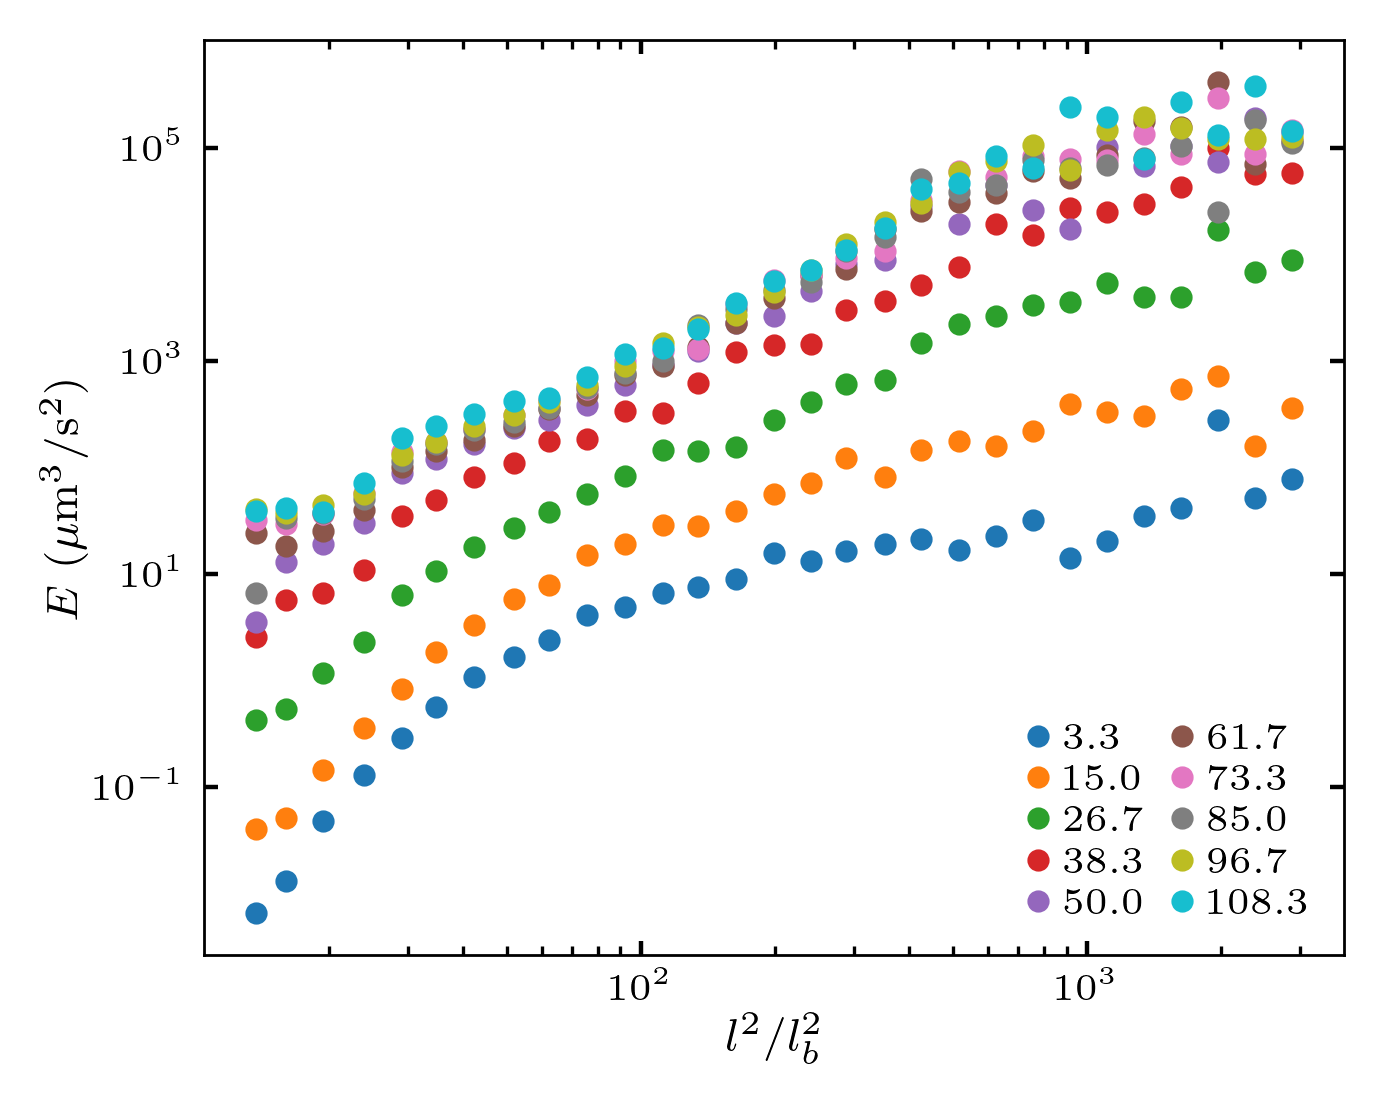

In [7]:
folder = os.path.join(data_master_dir, r'Research projects\DF\data\transient-GNF-energy\08032020\energy_spectra\02')
master = pd.read_csv(os.path.join(folder, r'energy_spectra.csv')).set_index('l_r')

selected_frames = master.keys()[2:len(master.keys()):7]
fig, ax = plt.subplots(figsize=(3.5, 2.8))
for frame in selected_frames:
    ax.plot(master.index, master[frame], 
            label='{:.1f}'.format(int(frame)/30), ls='', marker='o', markersize=3)
ax.legend(ncol=2, loc='lower right')
ax.loglog()
ax.set_xlabel('$l^2/l_b^2$')
ax.set_ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.tight_layout()